Non-local f matrix:
[0.   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
Non-local Jacobian matrix:
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -2.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -2.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. -2.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1. -2.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1. -2.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. -2.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1. -2.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1. -2.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  2. -2.]]
Non-local Jacobian matrix:
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -2.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -2.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. -2.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1. -2.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1. -2.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 

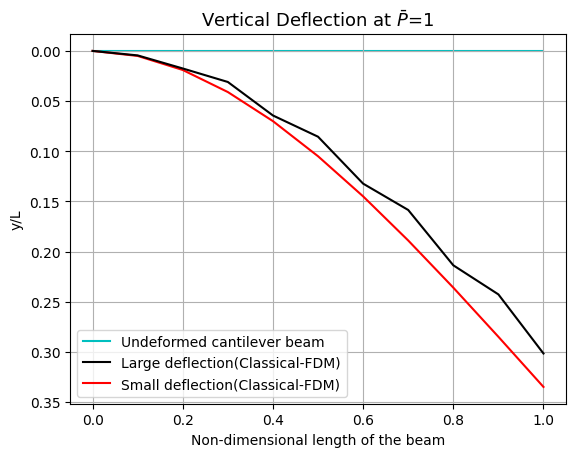

In [1]:
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import csv


# Change the value of m here #keep the number of nodes value 'm' as "odd"
m = 11  #(0 to i=m-1)
delta_s_bar = 1 / (m-1) #non-dimensional


#P_bar=(P*L**2)/(E*I)
P_bar = 1



A = P_bar * ((delta_s_bar) ** 2)


def non_local_slopes(a, b):
    def F(x):
        m = len(x)
        x[0], x[1], x[2], *_, x[m-1] = x
        f = [0] * m


        f[0] = x[0]
        f[1] = (a - 2*b) * x[0] - (2*a - 3*b) * x[1] + (a - 2*b) * x[2] + b*x[3] + A * np.cos(x[1])


        for i in range(2, m-2):
            f[i] = b * x[i-2] + (a - 2*b) * x[i-1] - (2*a - 2*b) * x[i] + (a - 2*b) * x[i+1] + b*x[i+2] + A * np.cos(x[i])

        f[m-2] = b * x[m-4] + (a - 2*b) * x[m-3] - (2*a - 3*b) * x[m-2] + (a - 2*b) * x[m-1] + A * np.cos(x[m-2])
        f[m-1] = (3*b/2) * x[m-3] + (2*a - 2*b) * x[m-2] - (2*a - (b/2)) * x[m-1] + A * np.cos(x[m-1])


        f = np.array(f)
        print("Non-local f matrix:")
        print(f)
        return f


    def Jacobian(x):
        m = len(x)
        x[0], x[1], x[2], *_, x[m-1] = x
        J = np.zeros([m, m])


        J[0, 0] = 1


        J[1, 0] = a - 2*b
        J[1, 1] = -(2*a - 3*b) - A * np.sin(x[1])
        J[1, 2] = a - 2*b
        J[1, 3] = b


        for j in range(2, m-2):
            J[j, j-2] = b
            J[j, j-1] = a - 2*b
            J[j, j] = -(2*a - 2*b) - A * np.sin(x[j])
            J[j, j+1] = a - 2*b
            J[j, j+2] = b



        J[m-2, m-4] = b
        J[m-2, m-3] = a - 2*b
        J[m-2, m-2] = -(2*a - 3*b) - A * np.sin(x[m-2])
        J[m-2, m-1] = a - 2*b


        J[m-1, m-3] = (3*b/2)
        J[m-1, m-2] = (2*a - 2*b)
        J[m-1, m-1] = -(2*a - (b/2)) - A * np.sin(x[m-1])


        J = np.array(J)
        print("Non-local Jacobian matrix:")
        print(J)
        return J


    x_guess = np.zeros(m)
    f_values = F(x_guess)
    J_matrix = Jacobian(x_guess)


    def newton_raphson(F, Jacobian, x_guess, max_iter=100, tolerance=1e-6):
        x = x_guess
        for _ in range(max_iter):
            delta_x = np.linalg.solve(Jacobian(x), -F(x))
            x = x + delta_x
            if np.linalg.norm(delta_x) < tolerance:
                break


        return x


    return newton_raphson(F, Jacobian, x_guess)


solution1 = non_local_slopes(a=1, b=0)


#vertical deflection calculated from the slope values


upper_l = 1
lower_l = 0

def F_cos(x):
    return math.cos(x)
def F_sin(x):
    return math.sin(x)


def simpsons_rule_integration(F_values):
    n = m - 1
    h = (upper_l - lower_l) / n
    R = np.zeros(m)
    R[0] = 0
    R[1] = (h / 2) * (F_values[0] + F_values[1])

    for i in range(2, m):
        R[i] = ((F_values[0] + F_values[i]) + (4 * np.sum(F_values[1:i:2])) + (2 * np.sum(F_values[2:i:2])))

        R[i] *= (h / 3)

    return R


F1_cos_values = np.array([F_cos(x_val) for x_val in solution1])
x1_values = simpsons_rule_integration(F1_cos_values)
F1_sin_values = np.array([F_sin(x_val) for x_val in solution1])
y1_values = simpsons_rule_integration(F1_sin_values)


print("Given below are vertical coordinates for classical problem solved using FDM using large deflection formula :")
for i, result in enumerate(y1_values):
    print("y[{}] = {}".format(i, result))


########small deflection part
def solve_equation(alfa,beta):


 A1=np.zeros([m+1,m+1])


 A1[0,0]=1


 A1[1,0]=-2*alfa+(beta/2)
 A1[1,1]=2*alfa-2*beta
 A1[1,2]=3*beta/2


 A1[2,0]=alfa-2*beta
 A1[2,1]=-(2*alfa-3*beta)
 A1[2,2]=alfa-2*beta
 A1[2,3]=beta


 for i in range(3,m):


  A1[i,i-3]=beta
  A1[i,i-2]=alfa-2*beta
  A1[i,i-1]=-(2*alfa-2*beta)
  A1[i,i]=alfa-2*beta
  A1[i,i+1]=beta


 A1[m,m-3]=3*beta/2
 A1[m,m-2]=alfa-5*beta/2
 A1[m,m-1]=-(2*alfa-(beta/2))
 A1[m,m]=alfa+(beta/2)


 B1=np.zeros([m+1,1])


 B1[0,0]=0
 B1[1,0]=(P_bar*(delta_s_bar**2))*(1-0)


 for j in range(2,m):
  B1[j,0]=P_bar*(delta_s_bar**2)*(1-((j-1)*delta_s_bar))




 B1[m,0]=0


 X1=linalg.solve(A1,B1)


 print("A=",A1)
 print("B=",B1)
 print("X=",X1)
 print()


 return X1


C=solve_equation(alfa=1,beta=0)
C_subset=C[:-1]

x = np.linspace(0, 1, m)
Y3 = (P_bar / 2) * (x ** 2 - (x ** 3) / 3) #analytical
print(Y3)

#table
combined_results = list(zip(C_subset,y1_values))
csv_file_path = 'small and large deflection,P_bar=1,m=11.csv'
with open(csv_file_path, mode='w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['Small Deflection(Classical-FDM)',
                         'Large Deflection(Classical-FDM)'])
    csv_writer.writerows(combined_results)




plt.figure()
# Drawing the undeformed cantilever beam

beam_y = np.zeros_like(x)
plt.plot(x, beam_y, 'c-',linewidth=1.5,label='Undeformed cantilever beam',zorder=1)
plt.plot(x, y1_values, color='k',linewidth=1.5,  label='Large deflection(Classical-FDM)',zorder=3)
plt.plot(x, C_subset, 'r-', linewidth=1.5, label='Small deflection(Classical-FDM)',zorder=2)
#plt.scatter(x, Y3,color= 'green', s=7, label='Analytical Method',zorder=4)
plt.xlabel('Non-dimensional length of the beam')
plt.ylabel('y/L')
plt.legend()
plt.title(r'Vertical Deflection at $\bar{P}$=1', fontsize=13)
plt.axis='equal'
plt.grid(True)
plt.gca().invert_yaxis()
plt.savefig("Small and large deflection,P_bar=1,n=11.pdf")
plt.show()